In [198]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import io
from ase.optimize import BFGS, LBFGS, FIRE, LBFGSLineSearch
from ase.visualize import view
from ase.io import Trajectory
from ase import Atoms
from ase.build import bulk
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True       
})


macemp0 = mace_mp(dispersion=True, default_dtype="float64", model="medium")
macemp = mace_mp(dispersion=True, default_dtype="float64")


Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/macempa0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [243]:
macemp_omat = mace_mp(model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/mace-omat-0-medium.model", dispersion=True, default_dtype="float64")
macemp_omat_noD = mace_mp(model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/mace-omat-0-medium.model", dispersion=False, default_dtype="float64")

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [3]:
import importlib
import interlayer_spacing
importlib.reload(interlayer_spacing)

from interlayer_spacing import calculate_interlayer_spacing, set_interlayer_spacing

### Setup

In [15]:
mxene_relaxed = io.read("structures/relaxed_mxene.xyz")
graphene_atoms = io.read("structures/graphene_atoms.xyz")

In [20]:
a = 3.03  

positions = [
    (0.0, 0.0, 0.5),  # C (middle layer)
    (1/3, 2/3, 0.35),  # Ti (bottom layer)
    (2/3, 1/3, 0.65),  # Ti (top layer)
    (1/3, 2/3, 0.80),  # O (top termination)
    (2/3, 1/3, 0.20),  # O (bottom termination)
]

symbols = ["C", "Ti", "Ti", "O", "O"]

cell = [
    [a, 0, 0],
    [-a/2, np.sqrt(3)/2 * a, 0],
    [0, 0, 20]
]

mxene_unit = Atoms(symbols=symbols, scaled_positions=positions, cell=cell, pbc=[True, True, False])

for atom in mxene_unit:
    if atom.symbol == 'O':
        if atom.position[2] < 0.5 * cell[2][2]:  # bottom O layer, fraction x cell parameter
            atom.tag = 1
        else:  # top O layer
            atom.tag = 3
    elif atom.symbol == 'C':
        atom.tag = 2
        

mxene_supercell = mxene_unit.repeat((4, 4, 1))
        
add_vacuum(mxene_supercell, 20.0)

In [21]:
mxene_relax_mp0 = mxene_supercell.copy()
mxene_relax_mp0.calc = macemp0
optimiser = BFGS(mxene_relax_mp0)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 14:29:09     -363.045908        1.157840
BFGS:    1 14:29:10     -363.694529        1.171301
BFGS:    2 14:29:11     -372.045322        1.359632
BFGS:    3 14:29:12     -381.539479        1.610541
BFGS:    4 14:29:13     -392.658177        1.983402
BFGS:    5 14:29:15     -406.550736        2.612705
BFGS:    6 14:29:16     -425.749539        3.647223
BFGS:    7 14:29:17     -456.084137        5.381531
BFGS:    8 14:29:18     -504.945867        6.516630
BFGS:    9 14:29:19     -558.855930        5.337270
BFGS:   10 14:29:20     -593.611944        2.763385
BFGS:   11 14:29:21     -605.978313        0.752172
BFGS:   12 14:29:22     -606.981325        0.474698
BFGS:   13 14:29:24     -607.502719        0.731859
BFGS:   14 14:29:25     -608.169773        0.930034
BFGS:   15 14:29:26     -610.781480        1.450060
BFGS:   16 14:29:27     -614.053925        1.902691
BFGS:   17 14:29:29     -617.497247        2.410251
BFGS:   18 14:

True

In [5]:
go = graphene_atoms.copy()
goh = graphene_atoms.copy()


# Add epoxy groups for GO (C/O = 50)
oxygen_positions = []
carbon_positions = go.get_positions()
num_carbons = len(carbon_positions)
num_oxygens = num_carbons // 50  # C/O ratio of 50

for i in range(num_oxygens):
    carbon_idx = np.random.randint(0, num_carbons)
    pos = carbon_positions[carbon_idx] - np.array([0, 0, 1.2])  # below carbon plane (in between carbon and mxene)
    oxygen_positions.append(pos)

go.extend(Atoms('O' * num_oxygens, positions=oxygen_positions))

# Add -OH groups for GOH
oxygen_positions = []
hydrogen_positions = []
for i in range(num_oxygens):
    carbon_idx = np.random.randint(0, num_carbons)
    pos_o = carbon_positions[carbon_idx] - np.array([0, 0, 1.53])
    pos_h = pos_o - np.array([0, 0, 0.98])
    oxygen_positions.append(pos_o)
    hydrogen_positions.append(pos_h)

goh.extend(Atoms('O' * num_oxygens, positions=oxygen_positions))
goh.extend(Atoms('H' * num_oxygens, positions=hydrogen_positions))

for atom in go:
    if atom.symbol == 'O':
        atom.tag = 11
for atom in goh:
    if atom.symbol == 'O':
        atom.tag = 11
    elif atom.symbol == 'H':
        atom.tag = 12

In [6]:
go_mace_relax = go.copy()
go_mace_relax.calc = macemp
optimiser = BFGS(go_mace_relax)
optimiser.run(fmax=0.001, steps=5000)

/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/torch_dftd/torch_dftd3_calculator.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  cell: Optional[Tensor] = torch.tensor(


      Step     Time          Energy          fmax
BFGS:    0 20:36:54     -466.334633       16.454457
BFGS:    1 20:36:55     -467.927597        4.451209
BFGS:    2 20:36:55     -468.205533        3.478318
BFGS:    3 20:36:56     -468.566415        2.968103
BFGS:    4 20:36:57     -468.663538        1.722527
BFGS:    5 20:36:57     -468.796102        0.628646
BFGS:    6 20:36:58     -468.833940        0.530242
BFGS:    7 20:36:59     -468.874182        0.646424
BFGS:    8 20:37:00     -468.904315        0.629228
BFGS:    9 20:37:00     -468.926669        0.335797
BFGS:   10 20:37:01     -468.938448        0.172961
BFGS:   11 20:37:01     -468.945834        0.353407
BFGS:   12 20:37:02     -468.954522        0.363407
BFGS:   13 20:37:03     -468.960837        0.186859
BFGS:   14 20:37:04     -468.964531        0.107849
BFGS:   15 20:37:05     -468.967109        0.123572
BFGS:   16 20:37:05     -468.969718        0.144892
BFGS:   17 20:37:06     -468.972667        0.105868
BFGS:   18 20:

True

In [7]:
io.write("go_mace_relax.xyz", go_mace_relax)

In [8]:
go_omat_relax = go.copy()
go_omat_relax.calc = macemp
optimiser = BFGS(go_omat_relax)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 20:37:31     -466.334633       16.454457
BFGS:    1 20:37:32     -467.927597        4.451209
BFGS:    2 20:37:33     -468.205533        3.478318
BFGS:    3 20:37:33     -468.566415        2.968103
BFGS:    4 20:37:34     -468.663538        1.722527
BFGS:    5 20:37:35     -468.796102        0.628646
BFGS:    6 20:37:36     -468.833940        0.530242
BFGS:    7 20:37:37     -468.874182        0.646424
BFGS:    8 20:37:38     -468.904315        0.629228
BFGS:    9 20:37:38     -468.926669        0.335797
BFGS:   10 20:37:39     -468.938448        0.172961
BFGS:   11 20:37:40     -468.945834        0.353407
BFGS:   12 20:37:40     -468.954522        0.363407
BFGS:   13 20:37:41     -468.960837        0.186859
BFGS:   14 20:37:42     -468.964531        0.107849
BFGS:   15 20:37:42     -468.967109        0.123572
BFGS:   16 20:37:43     -468.969718        0.144892
BFGS:   17 20:37:44     -468.972667        0.105868
BFGS:   18 20:

True

In [9]:
io.write("go_omat_relax.xyz", go_omat_relax)

In [10]:
goh_mace_relax = goh.copy()
goh_mace_relax.calc = macemp
optimiser = BFGS(goh_mace_relax)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 20:37:59     -471.348997        5.701374
BFGS:    1 20:38:00     -471.842760        4.356274
BFGS:    2 20:38:01     -472.122347        1.472360
BFGS:    3 20:38:02     -472.386861        0.884158
BFGS:    4 20:38:03     -472.460479        0.640650
BFGS:    5 20:38:04     -472.520095        0.433661
BFGS:    6 20:38:04     -472.555998        0.481005
BFGS:    7 20:38:05     -472.588486        0.412117
BFGS:    8 20:38:06     -472.611609        0.328050
BFGS:    9 20:38:07     -472.627673        0.209204
BFGS:   10 20:38:08     -472.638971        0.138085
BFGS:   11 20:38:09     -472.648315        0.190450
BFGS:   12 20:38:10     -472.655636        0.170904
BFGS:   13 20:38:11     -472.660850        0.114060
BFGS:   14 20:38:12     -472.664557        0.100348
BFGS:   15 20:38:13     -472.667780        0.120780
BFGS:   16 20:38:14     -472.671242        0.127540
BFGS:   17 20:38:14     -472.675051        0.099802
BFGS:   18 20:

True

In [11]:
io.write("goh_mace_relax.xyz", goh_mace_relax)

In [12]:
goh_omat_relax = goh.copy()
goh_omat_relax.calc = macemp
optimiser = BFGS(goh_omat_relax)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 20:38:43     -471.348997        5.701374
BFGS:    1 20:38:43     -471.842760        4.356274
BFGS:    2 20:38:44     -472.122347        1.472360
BFGS:    3 20:38:45     -472.386861        0.884158
BFGS:    4 20:38:46     -472.460479        0.640650
BFGS:    5 20:38:47     -472.520095        0.433661
BFGS:    6 20:38:48     -472.555998        0.481005
BFGS:    7 20:38:48     -472.588486        0.412117
BFGS:    8 20:38:49     -472.611609        0.328050
BFGS:    9 20:38:50     -472.627673        0.209204
BFGS:   10 20:38:51     -472.638971        0.138085
BFGS:   11 20:38:52     -472.648315        0.190450
BFGS:   12 20:38:53     -472.655636        0.170904
BFGS:   13 20:38:53     -472.660850        0.114060
BFGS:   14 20:38:54     -472.664557        0.100348
BFGS:   15 20:38:55     -472.667780        0.120780
BFGS:   16 20:38:56     -472.671242        0.127540
BFGS:   17 20:38:57     -472.675051        0.099802
BFGS:   18 20:

True

In [13]:
io.write("goh_omat_relax.xyz", goh_omat_relax)

In [52]:
go_mace_relax = io.read("structures/go_mace_relax.xyz")
go_omat_relax = io.read("structures/go_omat_relax.xyz")
goh_mace_relax = io.read("structures/goh_mace_relax.xyz")
goh_omat_relax = io.read("structures/goh_omat_relax.xyz")

In [6]:
from ase.build import add_vacuum

def vacuum_layer(atoms, vacuum = 20):
    # calculate the current vacuum size
    # create change to the desired vacuum size
    
    _, avg_z_C, avg_z_O_bottom = calculate_interlayer_spacing(atoms, avg_z=True, bottom=True)
    
    current_vacuum = atoms.cell[2][2] - avg_z_C + avg_z_O_bottom
    change = vacuum - current_vacuum

    return add_vacuum(atoms, change)


In [ ]:
from ase.constraints import FixedPlane

def constrain_spacing(atoms, OH=False):
    """
    Fix only the z positions of graphene and MXene layers while allowing in-plane (x, y) movement.
    """
    
    mxene_top_O_atoms = [atom.index for atom in atoms if atom.tag == 3]

    #mxene_atoms = [atom.index for atom in atoms if atom.tag in [1, 2, 3]]
    if OH == True:
        graphene_atoms = [atom.index for atom in atoms if atom.tag in [10, 11, 12]]
    else:
        graphene_atoms = [atom.index for atom in atoms if atom.tag == 10]

    # fix only z-movement, allow xy-movement
    constraints = [FixedPlane(idx, [0, 0, 1]) for idx in mxene_top_O_atoms + graphene_atoms]

    atoms.set_constraint(constraints)

    return atoms


In [8]:
def adhesion_energy(mxene, graphene, heterostructure):
    # a is the lattice constant of the MXene
    area = np.linalg.norm(np.cross(mxene.cell[0], mxene.cell[1]))  # cross product of the lattice vectors
    
    ad_energy = (mxene.get_total_energy() + graphene.get_total_energy() - heterostructure.get_total_energy()) / area
    return ad_energy * 100 # convert to eV/nm^2


In [9]:
def create_heterostructure(mxene, graphene_layer, height):
    # Stack MXene and graphene-based layer with a given interlayer spacing (height)
    graphene_layer = graphene_layer.copy()
    
    mxene_avg_top_O_z = np.mean([atom.position[2] for atom in mxene if atom.tag == 3])

    #mxene_avg_top_C_z = np.mean([atom.position[2] for atom in mxene if atom.symbol == 'C'])
    #mxene_avg_top_O_z = np.mean([atom.position[2] for atom in mxene if atom.symbol == 'O' and atom.position[2] > mxene_avg_top_C_z])
    
    graphene_layer.positions[:, 2] += mxene_avg_top_O_z - np.average(graphene_layer.positions[:, 2]) + height
    heterostructure = mxene + graphene_layer
    print("MXene avg top O z: ", mxene_avg_top_O_z)

    return heterostructure

In [46]:
m_g = create_heterostructure(mxene_relaxed, graphene_atoms, height=4.0)
m_go = create_heterostructure(mxene_relaxed, go_relax, height=4.0)
m_goh = create_heterostructure(mxene_relaxed, goh_relax, height=4.0)

MXene avg top O z:  12.23159545
MXene avg top O z:  12.23159545
MXene avg top O z:  12.23159545


In [58]:
np.linspace(2.8, 5.5, 20)

array([2.8       , 2.94210526, 3.08421053, 3.22631579, 3.36842105,
       3.51052632, 3.65263158, 3.79473684, 3.93684211, 4.07894737,
       4.22105263, 4.36315789, 4.50526316, 4.64736842, 4.78947368,
       4.93157895, 5.07368421, 5.21578947, 5.35789474, 5.5       ])

In [10]:
mxene_relaxed_mace = io.read("structures/mxene_relaxed_mace.xyz")
mxene_relaxed_omat = io.read("structures/mxene_relaxed_omat.xyz")

go_mace_relax = io.read("structures/go_mace_relax.xyz")
go_omat_relax = io.read("structures/go_omat_relax.xyz")
goh_mace_relax = io.read("structures/goh_mace_relax.xyz")
goh_omat_relax = io.read("structures/goh_omat_relax.xyz")

In [27]:
mxene_relaxed_mace.calc = macemp
graphene_atoms.calc = macemp

d = np.linspace(2.8, 5.5, 20)
ad_energy = []

for i in d:
    
    het = create_heterostructure(mxene_relaxed_mace, graphene_atoms, height=i)
    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/2opt_mg_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy.append(adhesion_energy(mxene_relaxed_mace, graphene_atoms, het))
    
    

MXene avg top O z:  12.23159545
       Step     Time          Energy          fmax
LBFGS:    0 14:44:18    -1192.140753       10.036643
LBFGS:    1 14:44:21    -1194.505712        7.835021
LBFGS:    2 14:44:24    -1197.750586        2.193101
LBFGS:    3 14:44:27    -1198.224495        0.871562
LBFGS:    4 14:44:30    -1198.366209        0.538837
LBFGS:    5 14:44:33    -1198.470947        0.273002
LBFGS:    6 14:44:36    -1198.481343        0.150681
LBFGS:    7 14:44:39    -1198.491655        0.146419
LBFGS:    8 14:44:43    -1198.498288        0.157715
LBFGS:    9 14:44:46    -1198.502789        0.092099
LBFGS:   10 14:44:49    -1198.504117        0.033058
LBFGS:   11 14:44:53    -1198.504490        0.022883
LBFGS:   12 14:44:56    -1198.504640        0.020192
LBFGS:   13 14:44:59    -1198.504730        0.015121
LBFGS:   14 14:45:02    -1198.504786        0.011502
LBFGS:   15 14:45:06    -1198.504829        0.011225
LBFGS:   16 14:45:09    -1198.504871        0.009307
MXene avg top O 

In [28]:
mxene_relaxed_omat.calc = macemp_omat
graphene_atoms.calc = macemp_omat

d = np.linspace(2.8, 5.5, 20)
ad_energy_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_omat, graphene_atoms, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/2opt_mg_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_omat.append(adhesion_energy(mxene_relaxed_omat, graphene_atoms, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 15:00:04    -1192.126565        9.781490
LBFGS:    1 15:00:07    -1194.342396        7.534290
LBFGS:    2 15:00:10    -1197.968526        2.414561
LBFGS:    3 15:00:13    -1198.342549        1.612808
LBFGS:    4 15:00:16    -1198.529636        0.555897
LBFGS:    5 15:00:19    -1198.610256        0.325919
LBFGS:    6 15:00:21    -1198.628917        0.191011
LBFGS:    7 15:00:24    -1198.637220        0.142944
LBFGS:    8 15:00:27    -1198.647603        0.167785
LBFGS:    9 15:00:30    -1198.653745        0.108640
LBFGS:   10 15:00:33    -1198.655075        0.038838
LBFGS:   11 15:00:36    -1198.655360        0.023798
LBFGS:   12 15:00:39    -1198.655512        0.024855
LBFGS:   13 15:00:42    -1198.655614        0.011101
LBFGS:   14 15:00:45    -1198.655655        0.006551
MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 15:00:54    -1192.978418   

In [48]:
mxene_relaxed_mace.calc = macemp
go_mace_relax.calc = macemp

ad_energy_go = []

for i in d:
    het = create_heterostructure(mxene_relaxed_mace, go_mace_relax, height=i)

    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = BFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/3opt_mgo_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_go.append(adhesion_energy(mxene_relaxed_mace, go_mace_relax, het))
    
    

MXene avg top O z:  12.23159545
      Step     Time          Energy          fmax
BFGS:    0 20:38:47    -1194.262826       10.138861
BFGS:    1 20:38:49    -1196.861495        8.610226
BFGS:    2 20:38:51    -1200.596276        2.713279
BFGS:    3 20:38:53    -1201.379971        1.961525
BFGS:    4 20:38:55    -1201.691622        1.358564
BFGS:    5 20:39:00    -1201.986170        0.542519
BFGS:    6 20:39:04    -1202.038101        0.405416
BFGS:    7 20:39:06    -1202.108507        0.268958
BFGS:    8 20:39:09    -1202.140874        0.284738
BFGS:    9 20:39:11    -1202.159536        0.214090
BFGS:   10 20:39:13    -1202.168258        0.184009
BFGS:   11 20:39:16    -1202.177292        0.184644
BFGS:   12 20:39:19    -1202.187556        0.193102
BFGS:   13 20:39:21    -1202.196796        0.160499
BFGS:   14 20:39:23    -1202.203215        0.113316
BFGS:   15 20:39:26    -1202.207571        0.098089
BFGS:   16 20:39:29    -1202.210876        0.096257
BFGS:   17 20:39:31    -1202.21356

In [31]:
mxene_relaxed_omat.calc = macemp_omat
go_omat_relax.calc = macemp_omat

ad_energy_go_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_omat, go_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)

    filename = f"adhesion_relax/2opt_mgo_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
    
    ad_energy_go_omat.append(adhesion_energy(mxene_relaxed_omat, go_omat_relax, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 16:42:20    -1193.879051        9.800889
LBFGS:    1 16:42:22    -1196.458069        8.214352
LBFGS:    2 16:42:25    -1200.460401        2.857934
LBFGS:    3 16:42:28    -1201.127309        2.159618
LBFGS:    4 16:42:31    -1201.514353        1.655636
LBFGS:    5 16:42:34    -1201.828251        0.805320
LBFGS:    6 16:42:37    -1201.916138        0.549706
LBFGS:    7 16:42:39    -1202.005658        0.318036
LBFGS:    8 16:42:42    -1202.061224        0.275335
LBFGS:    9 16:42:45    -1202.081382        0.163990
LBFGS:   10 16:42:48    -1202.088634        0.125834
LBFGS:   11 16:42:51    -1202.094678        0.115367
LBFGS:   12 16:42:54    -1202.102012        0.156312
LBFGS:   13 16:42:56    -1202.106690        0.110239
LBFGS:   14 16:43:00    -1202.109784        0.092475
LBFGS:   15 16:43:02    -1202.112321        0.071814
LBFGS:   16 16:43:05    -1202.114706        0.087996
LBFGS:   17 16:4

In [32]:
mxene_relaxed_mace.calc = macemp
goh_mace_relax.calc = macemp

ad_energy_goh = []

for i in d:
    het = create_heterostructure(mxene_relaxed_mace, goh_mace_relax, height=i)

    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)

    filename = f"adhesion_relax/2opt_mgoh_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_goh.append(adhesion_energy(mxene_relaxed_mace, goh_mace_relax, het))
    

MXene avg top O z:  12.23159545
       Step     Time          Energy          fmax
LBFGS:    0 17:12:26    -1192.810147       12.946201
LBFGS:    1 17:12:28    -1198.220953        7.869491
LBFGS:    2 17:12:30    -1201.957591        2.817185
LBFGS:    3 17:12:32    -1202.947685        2.431084
LBFGS:    4 17:12:34    -1203.474792        2.505282
LBFGS:    5 17:12:36    -1204.264113        2.873999
LBFGS:    6 17:12:37    -1204.599801        2.899328
LBFGS:    7 17:12:39    -1205.144288        2.416416
LBFGS:    8 17:12:41    -1205.516010        1.258900
LBFGS:    9 17:12:43    -1205.706866        1.419135
LBFGS:   10 17:12:45    -1205.839316        1.761214
LBFGS:   11 17:12:46    -1205.928733        1.524590
LBFGS:   12 17:12:48    -1206.050886        0.959780
LBFGS:   13 17:12:50    -1206.159456        0.518370
LBFGS:   14 17:12:52    -1206.187947        0.492478
LBFGS:   15 17:12:54    -1206.243381        0.581142
LBFGS:   16 17:12:56    -1206.261357        0.485243
LBFGS:   17 17:1

In [33]:
mxene_relaxed_omat.calc = macemp_omat
goh_omat_relax.calc = macemp_omat

ad_energy_goh_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_omat, goh_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/2opt_mgoh_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_goh_omat.append(adhesion_energy(mxene_relaxed_omat, goh_omat_relax, het))
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 17:52:58    -1191.809372       14.477140
LBFGS:    1 17:53:00    -1198.321172        7.240344
LBFGS:    2 17:53:02    -1202.258964        3.377857
LBFGS:    3 17:53:03    -1203.250409        2.682704
LBFGS:    4 17:53:05    -1203.881797        2.608153
LBFGS:    5 17:53:07    -1204.571867        2.650837
LBFGS:    6 17:53:09    -1204.952174        2.451813
LBFGS:    7 17:53:10    -1205.436100        2.074715
LBFGS:    8 17:53:12    -1205.798009        1.005107
LBFGS:    9 17:53:14    -1205.939516        0.976809
LBFGS:   10 17:53:16    -1206.005800        1.041131
LBFGS:   11 17:53:17    -1206.071793        0.645890
LBFGS:   12 17:53:19    -1206.121998        0.599295
LBFGS:   13 17:53:21    -1206.158326        0.517461
LBFGS:   14 17:53:23    -1206.187998        0.499199
LBFGS:   15 17:53:25    -1206.217091        0.376646
LBFGS:   16 17:53:27    -1206.234772        0.236249
LBFGS:   17 17:5

In [87]:
import glob
import re

def natural_sort_key(filename):
    #extracts numerical values from filename for natural sorting
    return [float(part) if part.replace('.', '', 1).isdigit() else part
            for part in re.split(r'(_|\.)', filename) if part]

# mg mace
file_list = glob.glob("adhesion_relax/opt_mg_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    graphene_atoms.calc = macemp
    ad_energy.append(adhesion_energy(mxene_relaxed_mace, graphene_atoms, io.read(filename)))
    
# mg mace omat
file_list = glob.glob("adhesion_relax/opt_mg_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_omat = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    graphene_atoms.calc = macemp_omat
    ad_energy_omat.append(adhesion_energy(mxene_relaxed_omat, graphene_atoms, io.read(filename)))
    
# mgo mace
file_list = glob.glob("adhesion_relax/opt_mgo_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    go_mace_relax.calc = macemp
    ad_energy_mgo.append(adhesion_energy(mxene_relaxed_mace, go_mace_relax, io.read(filename)))

# mgo mace omat
file_list = glob.glob("adhesion_relax/opt_mgo_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo_omat = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    go_omat_relax.calc = macemp_omat
    ad_energy_mgo_omat.append(adhesion_energy(mxene_relaxed_omat, go_omat_relax, io.read(filename)))

# mgoh mace
file_list = glob.glob("adhesion_relax/opt_mgoh_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    goh_mace_relax.calc = macemp
    ad_energy_mgoh.append(adhesion_energy(mxene_relaxed_mace, goh_mace_relax, io.read(filename)))

# mgoh mace omat
file_list = glob.glob("adhesion_relax/opt_mgoh_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_omat = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    goh_omat_relax.calc = macemp_omat
    ad_energy_mgoh_omat.append(adhesion_energy(mxene_relaxed_omat, goh_omat_relax, io.read(filename)))

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

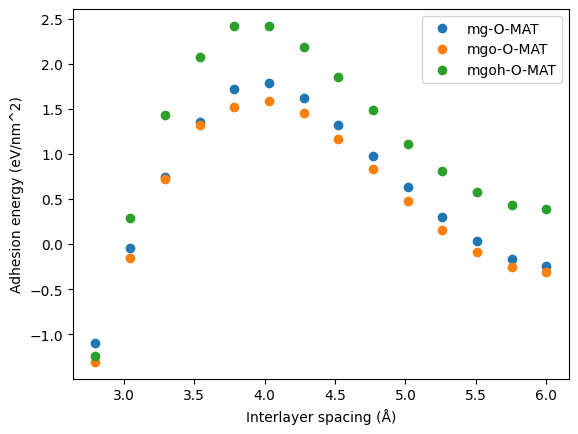

In [43]:
plt.plot(d, ad_energy_omat, linestyle='', marker='o', label="mg-O-MAT")
plt.plot(d, ad_energy_mgo_omat, linestyle='', marker='o', label="mgo-O-MAT")
plt.plot(d, ad_energy_mgoh_omat, linestyle='', marker='o', label="mgoh-O-MAT")

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

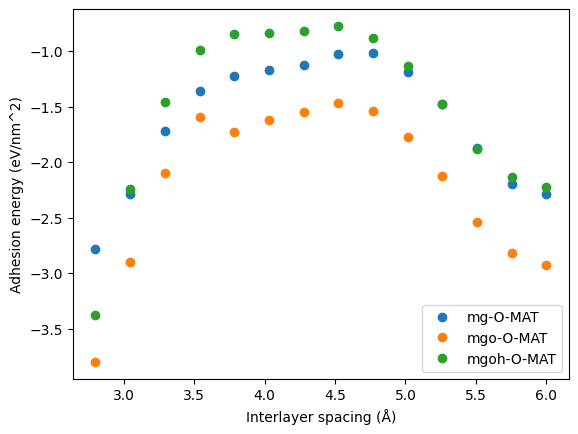

In [44]:
plt.plot(d, ad_energy, linestyle='', marker='o', label="mg-O-MAT")
plt.plot(d, ad_energy_mgo, linestyle='', marker='o', label="mgo-O-MAT")
plt.plot(d, ad_energy_mgoh, linestyle='', marker='o', label="mgoh-O-MAT")

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

In [151]:
import glob
import re

def natural_sort_key(filename):
    #extracts numerical values from filename for natural sorting
    return [float(part) if part.replace('.', '', 1).isdigit() else part
            for part in re.split(r'(_|\.)', filename) if part]

# mg mace
file_list = glob.glob("adhesion_relax/2opt_mg_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    graphene_atoms.calc = macemp
    ad_energy.append(adhesion_energy(mxene_relaxed_mace, graphene_atoms, io.read(filename)))
    
# mg mace omat
file_list = glob.glob("adhesion_relax/2opt_mg_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_omat = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    graphene_atoms.calc = macemp_omat
    ad_energy_omat.append(adhesion_energy(mxene_relaxed_omat, graphene_atoms, io.read(filename)))
    
# mgo mace
file_list = glob.glob("adhesion_relax/2opt_mgo_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    go_mace_relax.calc = macemp
    ad_energy_mgo.append(adhesion_energy(mxene_relaxed_mace, go_mace_relax, io.read(filename)))

# mgo mace omat
file_list = glob.glob("adhesion_relax/2opt_mgo_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo_omat = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    go_omat_relax.calc = macemp_omat
    ad_energy_mgo_omat.append(adhesion_energy(mxene_relaxed_omat, go_omat_relax, io.read(filename)))

# mgoh mace
file_list = glob.glob("adhesion_relax/2opt_mgoh_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    goh_mace_relax.calc = macemp
    ad_energy_mgoh.append(adhesion_energy(mxene_relaxed_mace, goh_mace_relax, io.read(filename)))

# mgoh mace omat
file_list = glob.glob("adhesion_relax/2opt_mgoh_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_omat = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    goh_omat_relax.calc = macemp_omat
    ad_energy_mgoh_omat.append(adhesion_energy(mxene_relaxed_omat, goh_omat_relax, io.read(filename)))

In [49]:
# mgo mace
file_list = glob.glob("adhesion_relax/3opt_mgo_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    ad_energy_mgo.append(adhesion_energy(mxene_relaxed, go_mace_relax, io.read(filename)))

In [39]:
np.where(ad_energy_omat == np.max(ad_energy_omat))[0][0]

8

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

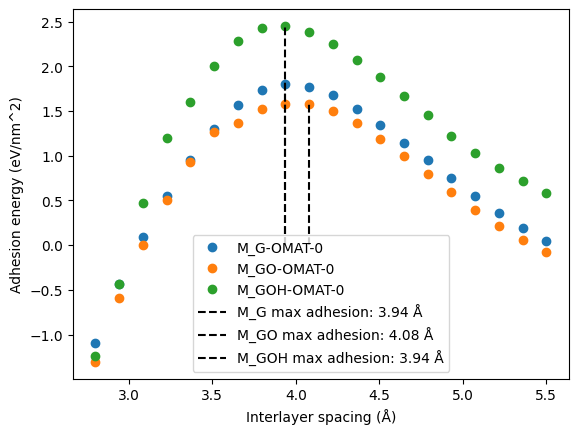

In [52]:
plt.plot(d, ad_energy_omat, linestyle='', marker='o', label="M_G-OMAT-0", color = 'C0')
plt.plot(d, ad_energy_mgo_omat, linestyle='', marker='o', label="M_GO-OMAT-0", color = 'C1')
plt.plot(d, ad_energy_mgoh_omat, linestyle='', marker='o', label="M_GOH-OMAT-0", color = 'C2')

mg_max_adhesion_d = d[np.where(ad_energy_omat == np.max(ad_energy_omat))[0][0]]
mgo_max_adhesion_d = d[np.where(ad_energy_mgo_omat == np.max(ad_energy_mgo_omat))[0][0]]
mgoh_max_adhesion_d = d[np.where(ad_energy_mgoh_omat == np.max(ad_energy_mgoh_omat))[0][0]]

plt.vlines(mg_max_adhesion_d, 0, np.max(ad_energy_omat), linestyle='--', color='black', label=f"M_G max adhesion: {mg_max_adhesion_d:.2f} Å")
plt.vlines(mgo_max_adhesion_d, 0, np.max(ad_energy_mgo_omat), linestyle='--', color='black', label=f"M_GO max adhesion: {mgo_max_adhesion_d:.2f} Å")
plt.vlines(mgoh_max_adhesion_d, 0, np.max(ad_energy_mgoh_omat), linestyle='--', color='black', label=f"M_GOH max adhesion: {mgoh_max_adhesion_d:.2f} Å")

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

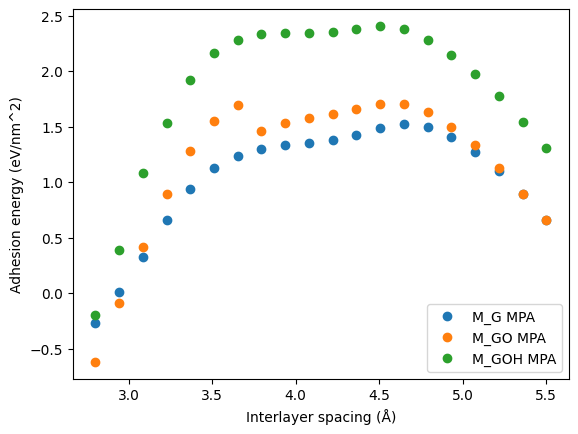

In [53]:
plt.plot(d, ad_energy, linestyle='', marker='o', label="M_G MPA", color = 'C0')
plt.plot(d, ad_energy_mgo, linestyle='', marker='o', label="M_GO MPA", color = 'C1')
plt.plot(d, ad_energy_mgoh, linestyle='', marker='o', label="M_GOH MPA", color = 'C2')

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

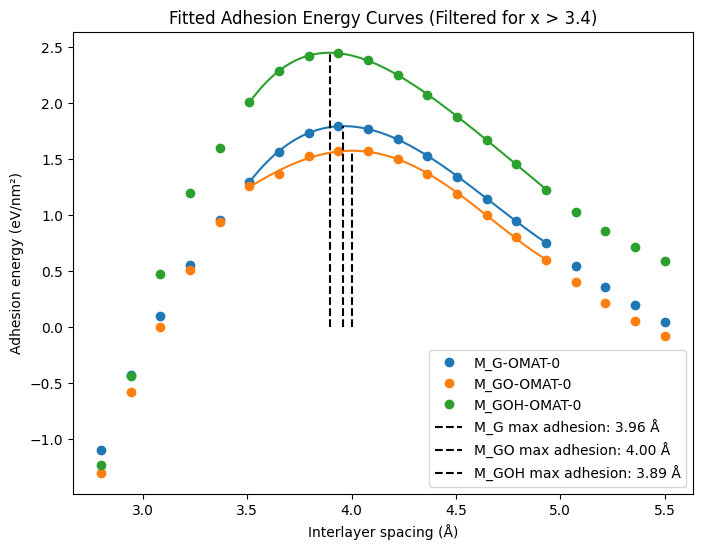

(3.9604788524417254,
 array(1.79494913),
 4.00319586541504,
 array(1.57443824),
 3.894979432549309,
 array(2.45092167))

In [157]:
from scipy.interpolate import UnivariateSpline

filtered_indices = np.where((d > 3.4) & (d < 5))[:]

# Apply filtering correctly
d_filtered = d[filtered_indices]
ad_energy_omat_filtered = np.array(ad_energy_omat)[filtered_indices]
ad_energy_mgo_omat_filtered = np.array(ad_energy_mgo_omat)[filtered_indices]
ad_energy_mgoh_omat_filtered = np.array(ad_energy_mgoh_omat)[filtered_indices]

# Fit smooth splines to the filtered dataset
spline_mg_filtered = UnivariateSpline(d_filtered, ad_energy_omat_filtered, s=0.1, k=4)
spline_mgo_filtered = UnivariateSpline(d_filtered, ad_energy_mgo_omat_filtered, s=0.1, k=4)
spline_mgoh_filtered = UnivariateSpline(d_filtered, ad_energy_mgoh_omat_filtered, s=0.1, k=4)

# Find max adhesion by evaluating the fitted splines in the filtered range
d_fine_filtered = np.linspace(d_filtered.min(), d_filtered.max(), 500)
max_d_mg_filtered = d_fine_filtered[np.argmax(spline_mg_filtered(d_fine_filtered))]
max_d_mgo_filtered = d_fine_filtered[np.argmax(spline_mgo_filtered(d_fine_filtered))]
max_d_mgoh_filtered = d_fine_filtered[np.argmax(spline_mgoh_filtered(d_fine_filtered))]

max_adhesion_mg_filtered = spline_mg_filtered(max_d_mg_filtered)
max_adhesion_mgo_filtered = spline_mgo_filtered(max_d_mgo_filtered)
max_adhesion_mgoh_filtered = spline_mgoh_filtered(max_d_mgoh_filtered)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(d, ad_energy_omat, 'o', label="M_G-OMAT-0", color='C0')
plt.plot(d_fine_filtered, spline_mg_filtered(d_fine_filtered), '-', color='C0')

plt.plot(d, ad_energy_mgo_omat, 'o', label="M_GO-OMAT-0", color='C1')
plt.plot(d_fine_filtered, spline_mgo_filtered(d_fine_filtered), '-', color='C1')

plt.plot(d, ad_energy_mgoh_omat, 'o', label="M_GOH-OMAT-0", color='C2')
plt.plot(d_fine_filtered, spline_mgoh_filtered(d_fine_filtered), '-', color='C2')

plt.vlines(max_d_mg_filtered,0, max_adhesion_mg_filtered, linestyle='--', color='black', label=f"M_G max adhesion: {max_d_mg_filtered:.2f} Å")
plt.vlines(max_d_mgo_filtered, 0, max_adhesion_mgo_filtered, linestyle='--', color='black', label=f"M_GO max adhesion: {max_d_mgo_filtered:.2f} Å")
plt.vlines(max_d_mgoh_filtered, 0, max_adhesion_mgoh_filtered, linestyle='--', color='black', label=f"M_GOH max adhesion: {max_d_mgoh_filtered:.2f} Å")

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm²)")
plt.title("Fitted Adhesion Energy Curves (Filtered for x > 3.4)")
plt.show()

# Return max adhesion points for the filtered dataset
max_d_mg_filtered, max_adhesion_mg_filtered, max_d_mgo_filtered, max_adhesion_mgo_filtered, max_d_mgoh_filtered, max_adhesion_mgoh_filtered


### Flipped

In [92]:
mxene_relaxed_flip_mace = io.read('structures/mxene_relaxed_flip_mace.xyz')
mxene_relaxed_flip_omat = io.read('structures/mxene_relaxed_flip_omat.xyz')


In [93]:
mxene_relaxed_flip_mace.calc = macemp
graphene_atoms.calc = macemp

d = np.linspace(2.8, 5.5, 20)
ad_energy = []

for i in d:
    
    het = create_heterostructure(mxene_relaxed_flip_mace, graphene_atoms, height=i)
    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mg_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy.append(adhesion_energy(mxene_relaxed_flip_mace, graphene_atoms, het))
    
    

MXene avg top O z:  12.23159545
       Step     Time          Energy          fmax
LBFGS:    0 23:03:46    -1192.201407        9.956648
LBFGS:    1 23:03:48    -1194.561031        7.519283
LBFGS:    2 23:03:50    -1197.790834        2.142208
LBFGS:    3 23:03:52    -1198.247169        0.826097
LBFGS:    4 23:03:53    -1198.380502        0.516418
LBFGS:    5 23:03:55    -1198.480189        0.284074
LBFGS:    6 23:03:57    -1198.490747        0.150159
LBFGS:    7 23:03:59    -1198.501153        0.142164
LBFGS:    8 23:04:01    -1198.507603        0.153619
LBFGS:    9 23:04:03    -1198.511984        0.092835
LBFGS:   10 23:04:05    -1198.513274        0.030074
LBFGS:   11 23:04:06    -1198.513641        0.022699
LBFGS:   12 23:04:08    -1198.513793        0.019646
LBFGS:   13 23:04:10    -1198.513886        0.015466
LBFGS:   14 23:04:12    -1198.513943        0.012004
LBFGS:   15 23:04:14    -1198.513988        0.010613
LBFGS:   16 23:04:16    -1198.514031        0.009340
MXene avg top O 

In [94]:
mxene_relaxed_flip_omat.calc = macemp_omat
graphene_atoms.calc = macemp_omat

d = np.linspace(2.8, 5.5, 20)
ad_energy_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_omat, graphene_atoms, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mg_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_omat.append(adhesion_energy(mxene_relaxed_flip_omat, graphene_atoms, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 23:13:17    -1192.140054        9.773863
LBFGS:    1 23:13:19    -1194.349971        7.492428
LBFGS:    2 23:13:21    -1197.978496        2.402590
LBFGS:    3 23:13:23    -1198.348979        1.589434
LBFGS:    4 23:13:25    -1198.532744        0.553551
LBFGS:    5 23:13:27    -1198.611937        0.323042
LBFGS:    6 23:13:28    -1198.630619        0.190542
LBFGS:    7 23:13:30    -1198.638899        0.144342
LBFGS:    8 23:13:32    -1198.649252        0.169252
LBFGS:    9 23:13:34    -1198.655356        0.107160
LBFGS:   10 23:13:36    -1198.656686        0.039400
LBFGS:   11 23:13:38    -1198.656975        0.024233
LBFGS:   12 23:13:40    -1198.657130        0.025313
LBFGS:   13 23:13:42    -1198.657234        0.011256
LBFGS:   14 23:13:44    -1198.657277        0.007174
MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 23:13:49    -1192.986538   

In [95]:
mxene_relaxed_flip_mace.calc = macemp
go_mace_relax.calc = macemp

ad_energy_go = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_mace, go_mace_relax, height=i)

    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = BFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mgo_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_go.append(adhesion_energy(mxene_relaxed_flip_mace, go_mace_relax, het))
    
    

MXene avg top O z:  12.23159545
      Step     Time          Energy          fmax
BFGS:    0 23:25:20    -1191.063561       13.777805
BFGS:    1 23:25:24    -1195.203909        8.344819
BFGS:    2 23:25:28    -1199.356016        4.721640
BFGS:    3 23:25:32    -1200.332878        2.114890
BFGS:    4 23:25:35    -1200.651823        1.241824
BFGS:    5 23:25:39    -1200.890707        1.050300
BFGS:    6 23:25:43    -1200.987860        1.468994
BFGS:    7 23:25:46    -1201.164055        1.689965
BFGS:    8 23:25:50    -1201.336319        1.548341
BFGS:    9 23:25:53    -1201.563140        0.898781
BFGS:   10 23:25:57    -1201.631591        0.509328
BFGS:   11 23:26:01    -1201.658507        0.436460
BFGS:   12 23:26:04    -1201.705871        0.382057
BFGS:   13 23:26:08    -1201.721733        0.327989
BFGS:   14 23:26:11    -1201.747145        0.234886
BFGS:   15 23:26:14    -1201.761185        0.200544
BFGS:   16 23:26:18    -1201.775559        0.221288
BFGS:   17 23:26:21    -1201.78537

In [96]:
mxene_relaxed_flip_omat.calc = macemp_omat
go_omat_relax.calc = macemp_omat

ad_energy_go_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_omat, go_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)

    filename = f"adhesion_relax/flip_opt_mgo_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
    
    ad_energy_go_omat.append(adhesion_energy(mxene_relaxed_flip_omat, go_omat_relax, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 00:22:07    -1190.704707       13.087637
LBFGS:    1 00:22:09    -1194.685210        8.328881
LBFGS:    2 00:22:12    -1199.166967        4.692146
LBFGS:    3 00:22:15    -1199.972820        1.913376
LBFGS:    4 00:22:17    -1200.318316        1.009490
LBFGS:    5 00:22:20    -1200.469171        0.619422
LBFGS:    6 00:22:23    -1200.528135        0.623954
LBFGS:    7 00:22:25    -1200.581768        0.619075
LBFGS:    8 00:22:28    -1200.634484        0.598626
LBFGS:    9 00:22:31    -1200.675878        0.558593
LBFGS:   10 00:22:34    -1200.712927        0.486289
LBFGS:   11 00:22:36    -1200.748944        0.393696
LBFGS:   12 00:22:39    -1200.786606        0.319845
LBFGS:   13 00:22:42    -1200.827032        0.363585
LBFGS:   14 00:22:44    -1200.882458        0.794728
LBFGS:   15 00:22:47    -1200.909760        1.158052
LBFGS:   16 00:22:50    -1200.986725        0.787265
LBFGS:   17 00:2

In [97]:
mxene_relaxed_flip_mace.calc = macemp
goh_mace_relax.calc = macemp

ad_energy_goh = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_mace, goh_mace_relax, height=i)

    het = constrain_spacing(het)

    het.calc = macemp
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)

    filename = f"adhesion_relax/flip_opt_mgoh_mace_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_goh.append(adhesion_energy(mxene_relaxed_flip_mace, goh_mace_relax, het))
    

MXene avg top O z:  12.23159545
       Step     Time          Energy          fmax
LBFGS:    0 01:00:00    -1191.591122       15.943998
LBFGS:    1 01:00:01    -1198.796939        5.977864
LBFGS:    2 01:00:03    -1201.743276        3.883249
LBFGS:    3 01:00:05    -1202.702902        2.810969
LBFGS:    4 01:00:07    -1203.211348        2.403855
LBFGS:    5 01:00:09    -1203.699890        1.550733
LBFGS:    6 01:00:10    -1203.873925        1.242955
LBFGS:    7 01:00:12    -1204.054526        0.916298
LBFGS:    8 01:00:14    -1204.143152        0.680501
LBFGS:    9 01:00:16    -1204.210766        0.613101
LBFGS:   10 01:00:18    -1204.274574        0.795851
LBFGS:   11 01:00:20    -1204.397828        1.668245
LBFGS:   12 01:00:22    -1204.431499        1.892471
LBFGS:   13 01:00:24    -1204.633799        2.196658
LBFGS:   14 01:00:26    -1204.796347        2.189473
LBFGS:   15 01:00:28    -1205.050823        2.608582
LBFGS:   16 01:00:30    -1205.200779        1.508339
LBFGS:   17 01:0

In [98]:
mxene_relaxed_flip_omat.calc = macemp_omat
goh_omat_relax.calc = macemp_omat

ad_energy_goh_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_omat, goh_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_opt_mgoh_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_goh_omat.append(adhesion_energy(mxene_relaxed_flip_omat, goh_omat_relax, het))
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 01:36:05    -1191.147860       16.727501
LBFGS:    1 01:36:07    -1199.043185        5.755465
LBFGS:    2 01:36:09    -1201.784826        2.436865
LBFGS:    3 01:36:11    -1202.483753        2.319560
LBFGS:    4 01:36:13    -1203.006117        2.469613
LBFGS:    5 01:36:15    -1203.517897        3.007607
LBFGS:    6 01:36:16    -1203.985743        2.917896
LBFGS:    7 01:36:18    -1204.285048        3.302405
LBFGS:    8 01:36:20    -1204.681860        1.689481
LBFGS:    9 01:36:21    -1205.133469        1.607265
LBFGS:   10 01:36:23    -1205.250788        1.449848
LBFGS:   11 01:36:25    -1205.575236        1.127999
LBFGS:   12 01:36:27    -1205.628651        0.827019
LBFGS:   13 01:36:29    -1205.681657        0.447944
LBFGS:   14 01:36:31    -1205.717011        0.259016
LBFGS:   15 01:36:32    -1205.729750        0.330097
LBFGS:   16 01:36:34    -1205.745984        0.368387
LBFGS:   17 01:3

In [256]:
import glob
import re

def natural_sort_key(filename):
    #extracts numerical values from filename for natural sorting
    return [float(part) if part.replace('.', '', 1).isdigit() else part
            for part in re.split(r'(_|\.)', filename) if part]

# mg mace
file_list = glob.glob("adhesion_relax/flip_opt_mg_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    graphene_atoms.calc = macemp
    ad_energy_flip.append(adhesion_energy(mxene_relaxed_flip_mace, graphene_atoms, io.read(filename)))
    
# mg mace omat
file_list = glob.glob("adhesion_relax/flip_opt_mg_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_omat_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    graphene_atoms.calc = macemp_omat
    ad_energy_omat_flip.append(adhesion_energy(mxene_relaxed_flip_omat, graphene_atoms, io.read(filename)))
    
# mgo mace
file_list = glob.glob("adhesion_relax/flip_opt_mgo_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    go_mace_relax.calc = macemp
    ad_energy_mgo_flip.append(adhesion_energy(mxene_relaxed_flip_mace, go_mace_relax, io.read(filename)))

# mgo mace omat
file_list = glob.glob("adhesion_relax/flip_opt_mgo_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo_omat_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    go_omat_relax.calc = macemp_omat
    ad_energy_mgo_omat_flip.append(adhesion_energy(mxene_relaxed_flip_omat, go_omat_relax, io.read(filename)))

# mgoh mace
file_list = glob.glob("adhesion_relax/flip_opt_mgoh_mace_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp
    goh_mace_relax.calc = macemp
    ad_energy_mgoh_flip.append(adhesion_energy(mxene_relaxed_flip_mace, goh_mace_relax, io.read(filename)))

# mgoh mace omat
file_list = glob.glob("adhesion_relax/flip_opt_mgoh_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_omat_flip = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    goh_omat_relax.calc = macemp_omat
    ad_energy_mgoh_omat_flip.append(adhesion_energy(mxene_relaxed_flip_omat, goh_omat_relax, io.read(filename)))

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

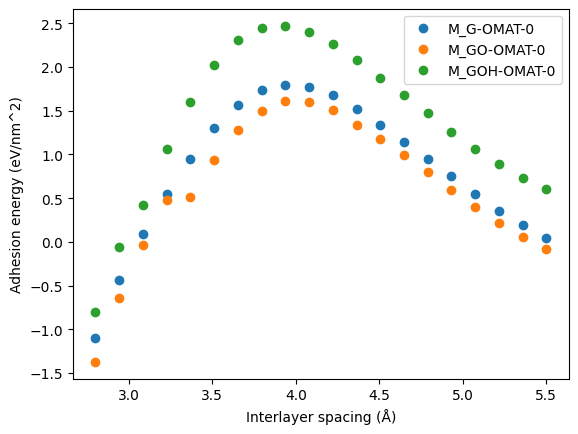

In [148]:
plt.plot(d, ad_energy_omat_flip, linestyle='', marker='o', label="M_G-OMAT-0", color = 'C0')
plt.plot(d, ad_energy_mgo_omat_flip, linestyle='', marker='o', label="M_GO-OMAT-0", color = 'C1')
plt.plot(d, ad_energy_mgoh_omat_flip, linestyle='', marker='o', label="M_GOH-OMAT-0", color = 'C2')

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

Text(0, 0.5, 'Adhesion energy (eV/nm^2)')

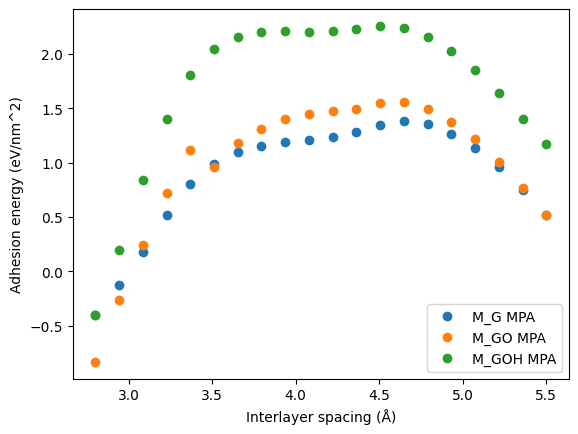

In [149]:
plt.plot(d, ad_energy_flip, linestyle='', marker='o', label="M_G MPA", color = 'C0')
plt.plot(d, ad_energy_mgo_flip, linestyle='', marker='o', label="M_GO MPA", color = 'C1')
plt.plot(d, ad_energy_mgoh_flip, linestyle='', marker='o', label="M_GOH MPA", color = 'C2')

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm^2)")

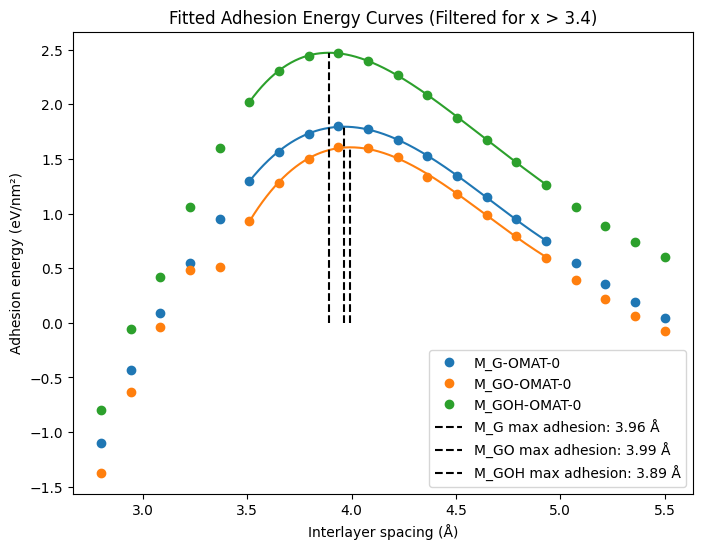

(3.9633266533066127,
 array(1.79465089),
 3.9946524628203774,
 array(1.60601177),
 3.8921316316844212,
 array(2.47127733))

In [ ]:
from scipy.interpolate import UnivariateSpline

filtered_indices = np.where((d > 3.4) & (d < 5))[:]

# Apply filtering correctly
d_filtered = d[filtered_indices]
ad_energy_omat_filtered = np.array(ad_energy_omat_flip)[filtered_indices]
ad_energy_mgo_omat_filtered = np.array(ad_energy_mgo_omat_flip)[filtered_indices]
ad_energy_mgoh_omat_filtered = np.array(ad_energy_mgoh_omat_flip)[filtered_indices]

# Fit smooth splines to the filtered dataset
spline_mg_filtered = UnivariateSpline(d_filtered, ad_energy_omat_filtered, s=0.1, k=4)
spline_mgo_filtered = UnivariateSpline(d_filtered, ad_energy_mgo_omat_filtered, s=0.1, k=4)
spline_mgoh_filtered = UnivariateSpline(d_filtered, ad_energy_mgoh_omat_filtered, s=0.1, k=4)

# Find max adhesion by evaluating the fitted splines in the filtered range
d_fine_filtered = np.linspace(d_filtered.min(), d_filtered.max(), 500)
max_d_mg_filtered = d_fine_filtered[np.argmax(spline_mg_filtered(d_fine_filtered))]
max_d_mgo_filtered = d_fine_filtered[np.argmax(spline_mgo_filtered(d_fine_filtered))]
max_d_mgoh_filtered = d_fine_filtered[np.argmax(spline_mgoh_filtered(d_fine_filtered))]

max_adhesion_mg_filtered = spline_mg_filtered(max_d_mg_filtered)
max_adhesion_mgo_filtered = spline_mgo_filtered(max_d_mgo_filtered)
max_adhesion_mgoh_filtered = spline_mgoh_filtered(max_d_mgoh_filtered)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(d, ad_energy_omat_flip, 'o', label="M_G-OMAT-0", color='C0')
plt.plot(d_fine_filtered, spline_mg_filtered(d_fine_filtered), '-', color='C0')

plt.plot(d, ad_energy_mgo_omat_flip, 'o', label="M_GO-OMAT-0", color='C1')
plt.plot(d_fine_filtered, spline_mgo_filtered(d_fine_filtered), '-', color='C1')

plt.plot(d, ad_energy_mgoh_omat_flip, 'o', label="M_GOH-OMAT-0", color='C2')
plt.plot(d_fine_filtered, spline_mgoh_filtered(d_fine_filtered), '-', color='C2')

plt.vlines(max_d_mg_filtered,0, max_adhesion_mg_filtered, linestyle='--', color='black', label=f"M_G max adhesion: {max_d_mg_filtered:.2f} Å")
plt.vlines(max_d_mgo_filtered, 0, max_adhesion_mgo_filtered, linestyle='--', color='black', label=f"M_GO max adhesion: {max_d_mgo_filtered:.2f} Å")
plt.vlines(max_d_mgoh_filtered, 0, max_adhesion_mgoh_filtered, linestyle='--', color='black', label=f"M_GOH max adhesion: {max_d_mgoh_filtered:.2f} Å")

plt.legend()
plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion energy (eV/nm²)")
plt.title("Fitted Adhesion Energy Curves (Filtered for x > 3.4)")
plt.show()

# Return max adhesion points for the filtered dataset
max_d_mg_filtered, max_adhesion_mg_filtered, max_d_mgo_filtered, max_adhesion_mgo_filtered, max_d_mgoh_filtered, max_adhesion_mgoh_filtered


Python(28618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


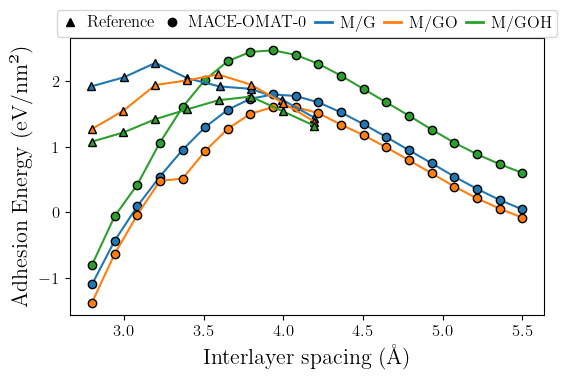

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(d, ad_energy_omat_flip, 'o-', label="M_G", markeredgecolor='black', color='C0')
plt.plot(d, ad_energy_mgo_omat_flip, 'o-', label="M_GO", markeredgecolor='black', color='C1')
plt.plot(d, ad_energy_mgoh_omat_flip, 'o-', label="M_GOH", markeredgecolor='black', color='C2')

plt.plot(values_x_mg, values_y_mg, label="M_G", marker="^", markeredgecolor='black', color='C0')
plt.plot(values_x_mgo, values_y_mgo, label="M_GO", marker="^", markeredgecolor='black', color='C1')
plt.plot(values_x_mgoh, values_y_mgoh, label="M_GOH", marker="^", markeredgecolor='black', color='C2')

legend_elements = [
    plt.Line2D([0], [0], linestyle="None", marker="^", color="black", label="Reference"),
    plt.Line2D([0], [0], linestyle="None", marker="o", color="black", label="MACE-OMAT-0"),
    plt.Line2D([0], [0], color="C0", lw=2, label="M/G"),
    plt.Line2D([0], [0], color="C1", lw=2, label="M/GO"),
    plt.Line2D([0], [0], color="C2", lw=2, label="M/GOH"),
]


#plt.legend(handles=legend_elements, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.13), frameon=True)
plt.legend(handles=legend_elements, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.13), frameon=True,
           columnspacing=0.5, handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=12, markerfirst=True)

plt.xlabel("Interlayer spacing (Å)", fontsize = 16)
plt.ylabel("Adhesion Energy (eV/nm²)", fontsize = 16)
plt.tight_layout()
#plt.savefig("figures/adhesion_energy.png", dpi=500)
plt.show()

### Reference data

In [160]:
import json

with open("ref_adhesion/adhesion_ref_MG.json", 'r') as f:
    adhesion_ref_MG = json.load(f)
with open("ref_adhesion/adhesion_ref_MGO.json", 'r') as f:
    adhesion_ref_MGO = json.load(f)
with open("ref_adhesion/adhesion_ref_MGOH.json", 'r') as f:
    adhesion_ref_MGOH = json.load(f)
    
values_x_mg = [i['value'][0] for i in adhesion_ref_MG['datasetColl'][0]['data']]
values_y_mg = [i['value'][1] for i in adhesion_ref_MG['datasetColl'][0]['data']]

values_x_mgo = [i['value'][0] for i in adhesion_ref_MGO['datasetColl'][0]['data']]
values_y_mgo = [i['value'][1] for i in adhesion_ref_MGO['datasetColl'][0]['data']]

values_x_mgoh = [i['value'][0] for i in adhesion_ref_MGOH['datasetColl'][0]['data']]
values_y_mgoh = [i['value'][1] for i in adhesion_ref_MGOH['datasetColl'][0]['data']]

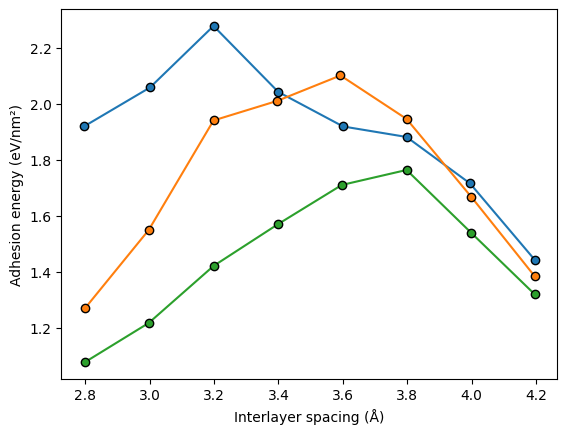

In [ ]:
plt.plot(values_x_mg, values_y_mg, label="M_G", marker="o", markeredgecolor='black', color='C0')
plt.plot(values_x_mgo, values_y_mgo, label="M_GO", marker="o", markeredgecolor='black', color='C1')
plt.plot(values_x_mgoh, values_y_mgoh, label="M_GOH", marker="o", markeredgecolor='black', color='C2')

plt.xlabel("Interlayer spacing (Å)")
plt.ylabel("Adhesion Energy (eV/nm²)")
plt.show()

### More datapoints around the maximum

In [245]:
mxene_relaxed_flip_omat = io.read('structures/mxene_relaxed_flip_omat.xyz')
graphene_atoms = io.read("structures/graphene_atoms.xyz")
go_omat_relax = io.read("structures/go_omat_relax.xyz")
goh_omat_relax = io.read("structures/goh_omat_relax.xyz")

In [207]:
np.linspace(3.85, 4.2 , 20)

array([3.85      , 3.86842105, 3.88684211, 3.90526316, 3.92368421,
       3.94210526, 3.96052632, 3.97894737, 3.99736842, 4.01578947,
       4.03421053, 4.05263158, 4.07105263, 4.08947368, 4.10789474,
       4.12631579, 4.14473684, 4.16315789, 4.18157895, 4.2       ])

In [208]:
d_max = np.linspace(3.85, 4.2 , 20)

In [246]:
mxene_relaxed_flip_omat.calc = macemp_omat
graphene_atoms.calc = macemp_omat

ad_energy_omat = []

for i in d_max:
    het = create_heterostructure(mxene_relaxed_flip_omat, graphene_atoms, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat_noD
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_noD_opt_mg_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_omat.append(adhesion_energy(mxene_relaxed_flip_omat, graphene_atoms, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 12:23:39    -1171.011142        9.880876
LBFGS:    1 12:23:40    -1172.913874        7.985770
LBFGS:    2 12:23:41    -1176.828251        2.553447
LBFGS:    3 12:23:43    -1177.193614        1.783412
LBFGS:    4 12:23:43    -1177.404602        0.559191
LBFGS:    5 12:23:44    -1177.489462        0.370408
LBFGS:    6 12:23:45    -1177.513887        0.210362
LBFGS:    7 12:23:46    -1177.522140        0.142305
LBFGS:    8 12:23:47    -1177.531755        0.168513
LBFGS:    9 12:23:48    -1177.539430        0.111708
LBFGS:   10 12:23:49    -1177.541304        0.050243
LBFGS:   11 12:23:50    -1177.541765        0.027185
LBFGS:   12 12:23:51    -1177.541985        0.028963
LBFGS:   13 12:23:52    -1177.542171        0.015938
LBFGS:   14 12:23:52    -1177.542274        0.010755
LBFGS:   15 12:23:53    -1177.542368        0.016158
LBFGS:   16 12:23:54    -1177.542475        0.021255
LBFGS:   17 12:2

KeyboardInterrupt: 

In [ ]:
mxene_relaxed_flip_omat.calc = macemp_omat
go_omat_relax.calc = macemp_omat

ad_energy_go_omat = []

for i in d_max:
    het = create_heterostructure(mxene_relaxed_flip_omat, go_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat_noD
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)

    filename = f"adhesion_relax/flip_noD_opt_mgo_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
    
    ad_energy_go_omat.append(adhesion_energy(mxene_relaxed_flip_omat, go_omat_relax, het))
    
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 14:23:16    -1198.936304        9.996860
LBFGS:    1 14:23:19    -1200.830822        8.306562
LBFGS:    2 14:23:23    -1204.933003        2.586896
LBFGS:    3 14:23:25    -1205.329930        1.862033
LBFGS:    4 14:23:28    -1205.556847        0.575447
LBFGS:    5 14:23:31    -1205.650912        0.576849
LBFGS:    6 14:23:34    -1205.690118        0.577302
LBFGS:    7 14:23:37    -1205.710071        0.563821
LBFGS:    8 14:23:40    -1205.743127        0.508827
LBFGS:    9 14:23:43    -1205.772829        0.404602
LBFGS:   10 14:23:46    -1205.787469        0.310763
LBFGS:   11 14:23:50    -1205.795070        0.244612
LBFGS:   12 14:23:52    -1205.801588        0.186351
LBFGS:   13 14:23:55    -1205.809042        0.160393
LBFGS:   14 14:23:58    -1205.813680        0.096546
LBFGS:   15 14:24:01    -1205.815668        0.057448
LBFGS:   16 14:24:04    -1205.816696        0.062011
LBFGS:   17 14:2

In [249]:
mxene_relaxed_flip_omat.calc = macemp_omat
goh_omat_relax.calc = macemp_omat

ad_energy_goh_omat = []

for i in d:
    het = create_heterostructure(mxene_relaxed_flip_omat, goh_omat_relax, height=i)

    het = constrain_spacing(het)

    #het.calc = macemp
    het.calc = macemp_omat_noD
    optimiser = LBFGS(het)
    optimiser.run(fmax=0.01, steps=5000)
    
    filename = f"adhesion_relax/flip_noD_opt_mgoh_omat_{i:.2f}".replace('.', '_')
    io.write(filename + ".xyz", het)
        
    ad_energy_goh_omat.append(adhesion_energy(mxene_relaxed_flip_omat, goh_omat_relax, het))
    

MXene avg top O z:  12.23008024
       Step     Time          Energy          fmax
LBFGS:    0 12:25:11    -1164.132470       16.727447
LBFGS:    1 12:25:12    -1171.977529        5.686220
LBFGS:    2 12:25:13    -1174.670293        2.490940
LBFGS:    3 12:25:14    -1175.378569        2.314561
LBFGS:    4 12:25:15    -1175.927521        2.455703
LBFGS:    5 12:25:16    -1176.455138        2.994741
LBFGS:    6 12:25:18    -1176.924444        3.085418
LBFGS:    7 12:25:19    -1177.271153        2.404006
LBFGS:    8 12:25:20    -1177.642267        1.698133
LBFGS:    9 12:25:21    -1178.153134        1.477217
LBFGS:   10 12:25:22    -1178.267982        1.223951
LBFGS:   11 12:25:23    -1178.568072        0.762050
LBFGS:   12 12:25:24    -1178.628635        0.658018
LBFGS:   13 12:25:26    -1178.682355        0.375553
LBFGS:   14 12:25:27    -1178.704082        0.306130
LBFGS:   15 12:25:28    -1178.718247        0.369489
LBFGS:   16 12:25:29    -1178.731021        0.402073
LBFGS:   17 12:2

In [250]:
file_list = glob.glob("adhesion_relax/flip_noD_opt_mgoh_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_omat_flip_max = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat_noD
    goh_omat_relax.calc = macemp_omat_noD
    ad_energy_mgoh_omat_flip_max.append(adhesion_energy(mxene_relaxed_flip_omat, goh_omat_relax, io.read(filename)))

Python(16663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


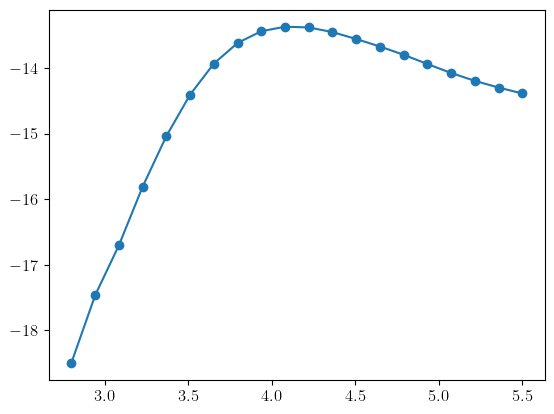

In [251]:
plt.plot(d, ad_energy_mgoh_omat_flip_max, marker="o", label = 'mgoh')


In [221]:
# mg mace omat
file_list = glob.glob("adhesion_relax/flip_maximum_opt_mg_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mg_omat_flip_max = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    graphene_atoms.calc = macemp_omat
    ad_energy_mg_omat_flip_max.append(adhesion_energy(mxene_relaxed_flip_omat, graphene_atoms, io.read(filename)))

# mgo mace omat
file_list = glob.glob("adhesion_relax/flip_maximum_opt_mgo_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgo_omat_flip_max = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    go_omat_relax.calc = macemp_omat
    ad_energy_mgo_omat_flip_max.append(adhesion_energy(mxene_relaxed_flip_omat, go_omat_relax, io.read(filename)))

# mgoh mace omat
file_list = glob.glob("adhesion_relax/flip_maximum_opt_mgoh_omat_*.xyz")
file_list.sort(key=natural_sort_key)
ad_energy_mgoh_omat_flip_max = []
for filename in file_list:
    mxene_relaxed.calc = macemp_omat
    goh_omat_relax.calc = macemp_omat
    ad_energy_mgoh_omat_flip_max.append(adhesion_energy(mxene_relaxed_flip_omat, goh_omat_relax, io.read(filename)))


In [229]:
d_max[np.argmax(ad_energy_mg_omat_flip_max)], d_max[np.argmax(ad_energy_mgo_omat_flip_max)], d_max[np.argmax(ad_energy_mgoh_omat_flip_max)]

(3.960526315789474, 3.9973684210526317, 3.905263157894737)

Python(54086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(54091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


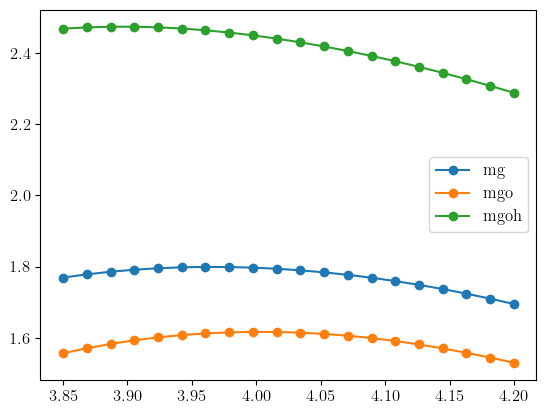

In [227]:
plt.plot(d_max, ad_energy_mg_omat_flip_max, marker="o", label = 'mg')
plt.plot(d_max, ad_energy_mgo_omat_flip_max, marker="o", label = 'mgo')
plt.plot(d_max, ad_energy_mgoh_omat_flip_max, marker="o", label = 'mgoh')
plt.legend()

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_55317/3327666869.py:8: RuntimeWarning: overflow encountered in exp
  morse = De * (np.exp(-2 * alpha * (d - de)) - 2 * np.exp(-alpha * (d - de)))
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_55317/3327666869.py:8: RuntimeWarning: invalid value encountered in subtract
  morse = De * (np.exp(-2 * alpha * (d - de)) - 2 * np.exp(-alpha * (d - de)))
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_55317/3327666869.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(morse_lj, d, ad_energy_omat_flip, p0=initial_guess)


Fitted parameters:
De = 1.3703
alpha = 7.5305
d_e = -29.6973 Å
epsilon = -1.425660 eV
sigma = 2.9138 Å


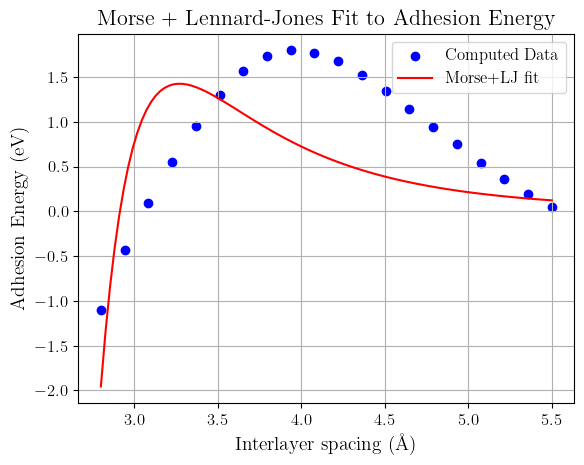

In [242]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Morse + Lennard-Jones combined potential

def morse_lj(d, De, alpha, de, epsilon, sigma):
    morse = De * (np.exp(-2 * alpha * (d - de)) - 2 * np.exp(-alpha * (d - de)))
    lj = 4 * epsilon * ((sigma / d)**12 - (sigma / d)**6)
    return morse + lj


# Initial guess parameters [De, alpha, de, epsilon, sigma]
initial_guess = [0.1, 1.0, 3.0, 0.1, 4]


# Fit the Morse + LJ potential
params, covariance = curve_fit(morse_lj, d, ad_energy_omat_flip, p0=initial_guess)

# Extract fitted parameters
De, alpha, de, epsilon, sigma = params

# Display fitted parameters
print(f"Fitted parameters:\nDe = {params[0]:.4f}\nalpha = {params[1]:.4f}\nd_e = {params[2]:.4f} Å\nepsilon = {params[3]:.6f} eV\nsigma = {params[4]:.4f} Å")

# Generate fitted curve for plotting
d_fit = np.linspace(min(d), max(d), 100)
E_fit = morse_lj(d_fit, *params)


plt.scatter(d, ad_energy_omat_flip, label='Computed Data', color='blue')
plt.plot(d_fit, E_fit, label='Morse+LJ fit', color='red')
plt.xlabel('Interlayer spacing (Å)')
plt.ylabel('Adhesion Energy (eV)')
plt.title('Morse + Lennard-Jones Fit to Adhesion Energy')
plt.legend()
plt.grid()
plt.show()
